<a href="https://colab.research.google.com/github/JJungEEun/Adversarial_AI_attack/blob/main/Adversarial_Patch/Adversarial_Patch_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[코드 구현] Adversarial_Patch_Attack**

- 작성자: 정은
- 논문 제목: [Adversarial Patch[(https://arxiv.org/pdf/1712.09665.pdf)
- 학습 데이터셋:
- ImageNet에서 Pytorch의 Adversarial Patch 구현
- Reference
  + https://github.com/A-LinCui/Adversarial_Patch_Attack
  + https://github.com/jhayes14/adversarial-patch


### 01. Make Patch

In [125]:
# Adversarial Patch: patch_utils
# utils for patch initialization and mask generation
# Created by Junbo Zhao 2020/3/19

import numpy as np
import torch

# Initialize the patch
def patch_initialization(patch_type='rectangle', image_size=(3, 224, 224), noise_percentage=0.03):
    if patch_type == 'rectangle':
        mask_length = int((noise_percentage * image_size[1] * image_size[2])**0.5)
        patch = np.random.rand(image_size[0], mask_length, mask_length)
    return patch

# Generate the mask and apply the patch
def mask_generation(mask_type='rectangle', patch=None, image_size=(3, 224, 224)):
    applied_patch = np.zeros(image_size)
    if mask_type == 'rectangle':
        # patch rotation
        rotation_angle = np.random.choice(4)
        for i in range(patch.shape[0]):
            patch[i] = np.rot90(patch[i], rotation_angle)  # The actual rotation angle is rotation_angle * 90
        # patch location
        x_location, y_location = np.random.randint(low=0, high=image_size[1]-patch.shape[1]), np.random.randint(low=0, high=image_size[2]-patch.shape[2])
        for i in range(patch.shape[0]):
            applied_patch[:, x_location:x_location + patch.shape[1], y_location:y_location + patch.shape[2]] = patch
    mask = applied_patch.copy()
    mask[mask != 0] = 1.0
    return applied_patch, mask, x_location, y_location

# Test the patch on dataset
def test_patch(patch_type, target, patch, test_loader, model):
    model.eval()
    test_total, test_actual_total, test_success = 0, 0, 0
    for (image, label) in test_loader:
        test_total += label.shape[0]
        assert image.shape[0] == 1, 'Only one picture should be loaded each time.'
        image = image.cuda()
        label = label.cuda()
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        if predicted[0] != label and predicted[0].data.cpu().numpy() != target:
            test_actual_total += 1
            applied_patch, mask, x_location, y_location = mask_generation(patch_type, patch, image_size=(3, 224, 224))
            applied_patch = torch.from_numpy(applied_patch)
            mask = torch.from_numpy(mask)
            perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
            perturbated_image = perturbated_image.cuda()
            output = model(perturbated_image)
            _, predicted = torch.max(output.data, 1)
            if predicted[0].data.cpu().numpy() == target:
                test_success += 1
    return test_success / test_actual_total

In [126]:
# Initialize the patch
patch = patch_initialization(args.patch_type, image_size=(3, 224, 224), noise_percentage=args.noise_percentage)
print('The shape of the patch is', patch.shape)


applied_patch, mask, x_location, y_location = mask_generation(args.patch_type, patch, image_size=(3, 224, 224))
print(applied_patch.shape, mask.shape, x_location, y_location)

The shape of the patch is (3, 70, 70)
(3, 224, 224) (3, 224, 224) 20 95


### 02. Load Data

In [127]:
# Adversarial Patch: utils
# Utils in need to generate the patch and test on the dataset.

import numpy as np
import csv
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [128]:
# Dataset 불러오기
# ImageNet이 너무 커 랜덤하게 데이터 추출
def dataloader(train_size, test_size, data_dir, batch_size, num_workers, total_num=50000):
    # ImageFolder -> transfrom -> DataLoader

    #ImageFolder의 인자: transform (이미지를 변형)
    # Shift, Rotate, 형변환 등을 할때 사용된다.
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), #좌우반전
        transforms.ToTensor(), #numpy -> Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

    test_transforms = transforms.Compose([
        transforms.Resize(size=(32,32)), #이미지 크기 강제 조정
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # index = np.arange(total_num)
    # np.random.shuffle(index)
    # train_index = index[:train_size]
    # test_index = index[train_size: (train_size + test_size)]

    # ImageFolder 객체는 root_dir, transform등을 인자를 받을 수 있으며, root_dir에는 최상위 경로를 적어주면 된다.
    # train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=train_transforms)
    # test_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=test_transforms)

    # train_dataset = torchvision.datasets.CIFAR10(root=args.data_dir, train=True, download=True, transform=train_transforms)
    # test_dataset = torchvision.datasets.CIFAR10(root=args.data_dir, train=False, download=True, transform=test_transforms)

    training_dataset = torchvision.datasets.CIFAR10(root=args.data_dir, train=True, download=True, transform=transformer)
    validation_dataset =  torchvision.datasets.CIFAR10(root=args.data_dir, train=False, download=True, transform=transformer)

    # print("train_dataset", train_dataset.class_to_idx)
    # print("test_dataset", test_dataset.class_to_idx)


    # DataLoader: ImageFolder 객체를 활용해 인스턴스를 생성한 후, 하나씩 데이터를 가지고오는 작업 수행
    # DataLoader 클래스는 ImageFolder로부터 생성된 인스턴스를 인자로 받아 Load하는 기능을 가지고 있다.

    training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=1, num_workers=args.num_workers,shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1, num_workers=args.num_workers,shuffle=False)

    # train_loader = DataLoader(dataset=train_dataset, batch_size=100, num_workers=num_workers, pin_memory=True, shuffle=False) 
    # test_loader = DataLoader(dataset=test_dataset, batch_size=100,  num_workers=num_workers, pin_memory=True, shuffle=False)
    # batch: 반복문 돌 때 몇개의 이미지를 가져올지
    # sampler: 데이터 불균형 관련
    # num_worker: I/O 작업 시 사용할 CPU의 수
    # suffle: 이미지 랜덤하게 섞을 지

    return training_loader, validation_loader


Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 224, 224])


IndexError: ignored

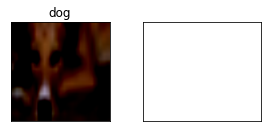

In [129]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

transformer = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), #좌우반전
        transforms.ToTensor(), #numpy -> Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

training_dataset = torchvision.datasets.CIFAR10(root=args.data_dir, train=True, download=True, transform=transformer)
validation_dataset =  torchvision.datasets.CIFAR10(root=args.data_dir, train=False, download=True, transform=transformer)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=1, num_workers=args.num_workers,shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1, num_workers=args.num_workers,shuffle=False)

def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  print(images[i].shape)
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


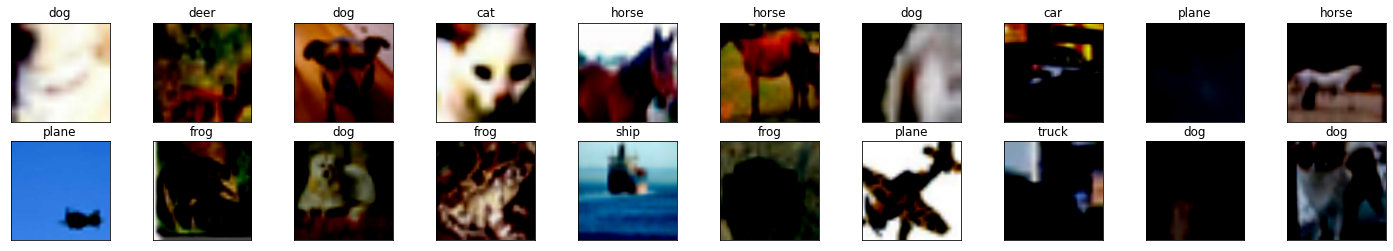

In [101]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  print(i)
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])

In [130]:
# Test the model on clean dataset
def test(model, dataloader):
    model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
          if args.cuda:
            images = images.cuda()         
            labels = labels.cuda()
      
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct / total

# Load the log and generate the training line
def log_generation(log_dir):
    # Load the statistics in the log
    epochs, train_rate, test_rate = [], [], []
    with open(log_dir, 'r') as f:
        reader = csv.reader(f)
        flag = 0
        for i in reader:
            if flag == 0:
                flag += 1
                continue
            else:
                epochs.append(int(i[0]))
                train_rate.append(float(i[1]))
                test_rate.append(float(i[2]))

    # Generate the success line
    plt.figure(num=0)
    plt.plot(epochs, test_rate, label='test_success_rate', linewidth=2, color='r')
    plt.plot(epochs, train_rate, label='train_success_rate', linewidth=2, color='b')
    plt.xlabel("epoch")
    plt.ylabel("success rate")
    plt.xlim(-1, max(epochs) + 1)
    plt.ylim(0, 1.0)
    plt.title("patch attack success rate")
    plt.legend()
    plt.savefig("training_pictures/patch_attack_success_rate.png")
    plt.close(0)

### 03. Adversarial Patch 공격

In [131]:
# Adversarial Patch Attack

"""
Reference:
[1] Tom B. Brown, Dandelion Mané, Aurko Roy, Martín Abadi, Justin Gilmer
    Adversarial Patch. arXiv:1712.09665
"""

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models

import argparse
import csv
import os
import numpy as np

import easydict
# EasyDict: dict 값에 액세스 할 수 있음(재귀적으로) 
 
args = easydict.EasyDict({
        "batch_size": 1,
        "num_workers": 0,
        "train_size": 2000,
        "test_size": 2000,
        "noise_percentage": 0.1,
        "probability_threshold": 0.9,
        "patch_type": "rectangle",
        "lr": 1.0,
        "max_iteration": 1000,
        "target": 3,
        "epochs": 20,
        "data_dir":"/content/drive/MyDrive/Colab Notebooks/dataset" ,
        "GPU": "PCI_BUS_ID",
        "log_dir": 'patch_attack_log.csv',
        "cuda": 'store_true'
})


#### Optimazation

In [132]:
# Patch attack via optimization
# According to reference [1], one image is attacked each time
# Assert: applied patch should be a numpy
# Return the final perturbated picture and the applied patch. Their types are both numpy
def patch_attack(image, applied_patch, mask, target, probability_threshold, model, lr=1, max_iteration=100):
    model.eval()
    applied_patch = torch.from_numpy(applied_patch)
    mask = torch.from_numpy(mask)
    target_probability, count = 0, 0
    perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
    while target_probability < probability_threshold and count < max_iteration:
        count += 1
        # Optimize the patch
        perturbated_image = Variable(perturbated_image.data, requires_grad=True)
        per_image = perturbated_image
        per_image = per_image.cuda()
        output = model(per_image)
        target_log_softmax = torch.nn.functional.log_softmax(output, dim=1)[0][target]
        target_log_softmax.backward()
        patch_grad = perturbated_image.grad.clone().cpu()
        perturbated_image.grad.data.zero_()
        applied_patch = lr * patch_grad + applied_patch.type(torch.FloatTensor)
        applied_patch = torch.clamp(applied_patch, min=-3, max=3)
        # Test the patch
        perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1-mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
        perturbated_image = torch.clamp(perturbated_image, min=-3, max=3)
        perturbated_image = perturbated_image.cuda()
        output = model(perturbated_image)
        target_probability = torch.nn.functional.softmax(output, dim=1).data[0][target]
    perturbated_image = perturbated_image.cpu().numpy()
    applied_patch = applied_patch.cpu().numpy()
    return perturbated_image, applied_patch

In [133]:
# os.environ["CUDA_VISIBLE_DEVICES"] = args.GPU

# Load the model
model = models.resnet50(pretrained=True).cuda()


데이터셋 불러오기

In [134]:
train_loader, test_loader = dataloader(args.train_size, args.test_size, args.data_dir, args.batch_size, args.num_workers, 50000)

Files already downloaded and verified
Files already downloaded and verified


**Error**

FileNotFoundError: Found no valid file for the classes 제목없는 폴더 (2). Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp


[root_dir의 구조]


    | --- cat/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- 0003.jpg
    |      |-- ...
    |
    
    | --- dog/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- 0003.jpg
    |      |-- ...
    |
    
    | --- rabbit/
    |      |--...

https://computistics.tistory.com/7

#### 정확도 검증


In [105]:
# Test the accuracy of model on trainset and testset
trainset_acc, test_acc = test(model, train_loader), test(model, test_loader)
print('Accuracy of the model on clean trainset and testset is {:.3f}% and {:.3f}%'.format(100*trainset_acc, 100*test_acc))

Accuracy of the model on clean trainset and testset is 0.046% and 0.040%


**Error1**

IndexError: Caught IndexError in DataLoader worker process 0.

- 아주 세밀한 원인까지는 파악하지 못했으나, torch의 dataloader 객체에 num_workers 인자를 높은 값으로 지정하여 스레드를 할당하는 과정에서 문제가 생긴 것으로 보입니다.

[해결 방법]

num_workers = 0

---

**Error2**
IndexError: list index out of range

- 이유 모르겠음
- ImageNet의 부재 ?

[해결방법] cifar 데이터로 수정

---

**Error3**
IndexError: index 43274 is out of bounds for axis 0 with size 10000


#### patch

패치 초기화

In [135]:
# Initialize the patch
patch = patch_initialization(args.patch_type, image_size=(3, 224, 224), noise_percentage=args.noise_percentage)
print('The shape of the patch is', patch.shape)

The shape of the patch is (3, 70, 70)


In [ ]:
with open(args.log_dir, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_success", "test_success"])

best_patch_epoch, best_patch_success_rate = 0, 0

# Generate the patch
for epoch in range(args.epochs):
    train_total, train_actual_total, train_success = 0, 0, 0
    for (image, label) in train_loader:
        train_total += label.shape[0]
        assert image.shape[0] == 1, "Only one picture should be loaded each time."
        image = image.cuda()
        label = label.cuda()
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        if predicted[0] != label and predicted[0].data.cpu().numpy() != args.target:
             train_actual_total += 1
             applied_patch, mask, x_location, y_location = mask_generation(args.patch_type, patch, image_size=(3, 224, 224))
             perturbated_image, applied_patch = patch_attack(image, applied_patch, mask, args.target, args.probability_threshold, model, args.lr, args.max_iteration)
             perturbated_image = torch.from_numpy(perturbated_image).cuda()
             output = model(perturbated_image)
             _, predicted = torch.max(output.data, 1)
             if predicted[0].data.cpu().numpy() == args.target:
                 train_success += 1
             patch = applied_patch[0][:, x_location:x_location + patch.shape[1], y_location:y_location + patch.shape[2]]
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    plt.imshow(np.clip(np.transpose(patch, (1, 2, 0)) * std + mean, 0, 1))
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/training_pictures/" + str(epoch) + " patch.png")
    print("Epoch:{} Patch attack success rate on trainset: {:.3f}%".format(epoch, 100 * train_success / train_actual_total))
    train_success_rate = test_patch(args.patch_type, args.target, patch, test_loader, model)
    print("Epoch:{} Patch attack success rate on trainset: {:.3f}%".format(epoch, 100 * train_success_rate))
    test_success_rate = test_patch(args.patch_type, args.target, patch, test_loader, model)
    print("Epoch:{} Patch attack success rate on testset: {:.3f}%".format(epoch, 100 * test_success_rate))

    # Record the statistics
    with open(args.log_dir, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_success_rate, test_success_rate])

    if test_success_rate > best_patch_success_rate:
        best_patch_success_rate = test_success_rate
        best_patch_epoch = epoch
        plt.imshow(np.clip(np.transpose(patch, (1, 2, 0)) * std + mean, 0, 1))
        plt.savefig("/content/drive/MyDrive/Colab Notebooks/training_pictures/best_patch.png")

    # Load the statistics and generate the line
    log_generation(args.log_dir)

print("The best patch is found at epoch {} with success rate {}% on testset".format(best_patch_epoch, 100 * best_patch_success_rate))